__Group Name__ : __Data Dynamo__
1. Roy, Abhijith; `abhijithroy.roy@carelon.com`,
2. Acharya, Ananth; `ananth.acharya@carelon.com`; 
3. Kumar, Diwakar; `diwakar.kumar@carelon.com`; 
4. Gouse, Mohammad; `mohammad.gouse@carelon.com`;
5. Peketi, Santhosh; `santhosh.peketi@carelon.com`, 

## Coding Transformer from scratch to perform Machine Translation Task

__The dataset is a subset of the IWSLT dataset consisting of TEDx Talks that are available in both french and english parallel corpuses__

## Importing Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import  TextVectorization, Embedding, Layer
import numpy as np## Importing Dependencies
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import re
import time
from nltk.translate.bleu_score import sentence_bleu

In [4]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_datasets.core.logging as _tfds_logging

## Loading the train, dev, and test sets of french and english corpora

In [2]:
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\train.en",
          mode='r',
          encoding='utf-8') as f:
    eurotrain_en = f.read()## Loading the train, dev, and test sets of french and english corpora
    
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\train.fr",
          mode='r',
          encoding='utf-8') as f:
    eurotrain_fr = f.read()
    
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\dev.en",
          mode='r',
          encoding='utf-8') as f:
    eurodev_en = f.read()
    
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\dev.fr",
          mode='r',
          encoding='utf-8') as f:
    eurodev_fr = f.read()
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\test.en",
          mode='r',
          encoding='utf-8') as f:
    eurotest_en = f.read()
    
with open(r"C:\Users\AL56154\OneDrive - Elevance Health\Desktop\workshop_material\Total training material\Transformers_data\Transformers_data\test.fr",
          mode='r',
          encoding='utf-8') as f:
    eurotest_fr = f.read()  
    



In [92]:
eurodev_fr[:1000]

"Vous savez, un des plaisirs intenses du voyage et un des délices de la recherche ethnographique est la possibilité de vivre parmi ceux qui n'ont pas oublié les anciennes coutumes, qui ressentent encore leur passé souffler dans le vent, qui le touchent dans les pierres polies par la pluie, le dégustent dans les feuilles amères des plantes.\nLe fait de savoir que les Jaguar shaman voyagent toujours au-delà de la voie lactée, ou que les mythes des anciens Inuit résonnent encore de sens, ou bien que dans l'Himalaya, les Bouddhistes continuent à rechercher le souffle du Dharma, c'est se rappeler de la révélation essentielle de l'anthropologie, et cela veut dire que le monde dans lequel nous vivons n'existe pas dans un sens absolu, mais est uniquement un exemple de réalité, la conséquence d'un ensemble spécifique de choix adaptés établis par notre lignée avec succès, il y a plusieurs générations.\nBien sûr, nous partageons tous les mêmes impératifs d'adaptation.\nNous sommes tous nés. Nous 

## Preprocessing the corpus






In [3]:
#CLEANING THE ENGLISH TEXT
corpus_en = eurotrain_en
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])"," ", corpus_en)
corpus_en = corpus_en.split('\n')


#CLEANING THE ENGLISH TEXT
corpus_en_test = eurotest_en
corpus_en_test = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])"," ", corpus_en_test)
corpus_en_test = corpus_en_test.split('\n')

#CLEANING THE ENGLISH TEXT
corpus_fr_test = eurotest_fr
corpus_fr_test = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])"," ", corpus_fr_test)
corpus_fr_test = corpus_fr_test.split('\n')

#CLEANING THE FRENCH TEXT
corpus_fr = eurotrain_fr
corpus_fr = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])"," ", corpus_fr)
corpus_fr = corpus_fr.split('\n')

In [93]:
corpus_en[:10]

["David Gallo: This is Bill Lange. I'm Dave Gallo.",
 "And we're going to tell you some stories from the sea here in video.",
 "We've got some of the most incredible video of Titanic that's ever been seen, and we're not going to show you any of it.",
 "The truth of the matter is that the Titanic -- even though it's breaking all sorts of box office records -- it's not the most exciting story from the sea.",
 'And the problem, I think, is that we take the ocean for granted.',
 'When you think about it, the oceans are 75 percent of the planet.',
 'Most of the planet is ocean water.',
 'The average depth is about two miles.',
 "Part of the problem, I think, is we stand at the beach, or we see images like this of the ocean, and you look out at this great big blue expanse, and it's shimmering and it's moving and there's waves and there's surf and there's tides, but you have no idea for what lies in there.",
 'And in the oceans, there are the longest mountain ranges on the planet.']

### Building Vocabulary

In [5]:
# Tokenizer for English
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size=2**13)### Building vocab using training set only

# Tokenizer for French
tokenizer_fr = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus_fr, target_vocab_size=2**13)

In [6]:
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2 # = 8190
VOCAB_SIZE_FR = tokenizer_fr.vocab_size + 2 # = 8171

## Encoding train and test sets each set with the respective language tokenizer

## Adding __\<SOS\>__ and __\<EOS\>__ tags
- Adding the Start of Sentence and End of Sentence tags to the corpus is to indicate the transformer the beginning and end of sentence for better sequential data processing.

In [7]:
inputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1] 
          for sentence in corpus_en]

outputs = [[VOCAB_SIZE_FR-2] + tokenizer_fr.encode(sentence) + [VOCAB_SIZE_FR-1]
           for sentence in corpus_fr]

inputs_test = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in corpus_en_test]

outputs_test = [[VOCAB_SIZE_FR-2] + tokenizer_fr.encode(sentence) + [VOCAB_SIZE_FR-1]
           for sentence in corpus_fr_test]



# Removing very long sentences

In [9]:
# Removing very long sentencesMAX_LENGTH = 40
# Use enumerate to capture indexes
idx_to_remove = [count for count, sent in enumerate(inputs)
                 if len(sent) > MAX_LENGTH]

# Remove long sentences by index
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

# Rinse and repeate!    
idx_to_remove = [count for count, sent in enumerate(outputs)
                 if len(sent) > MAX_LENGTH]

for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
    
idx_to_remove = [count for count, sent in enumerate(inputs_test)
                 if len(sent) > MAX_LENGTH]

# Remove long sentences by index
for idx in reversed(idx_to_remove):
    del inputs_test[idx]
    del outputs_test[idx]

# Rinse and repeate!    
idx_to_remove = [count for count, sent in enumerate(outputs_test)
                 if len(sent) > MAX_LENGTH]

for idx in reversed(idx_to_remove):
    del inputs_test[idx]
    del outputs_test[idx]

# Padding the sentences

In [10]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       value=0,
                                              # Padding the sentences         padding='post',
                                                       maxlen=MAX_LENGTH)

outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_LENGTH)
inputs_test = tf.keras.preprocessing.sequence.pad_sequences(inputs_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=MAX_LENGTH)

outputs_test = tf.keras.preprocessing.sequence.pad_sequences(outputs_test,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_LENGTH)

# Creation of train and test Datasets (tf.data.Dataset)

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000# Creation of Datasets (tf.data.Dataset)

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


dataset_test = tf.data.Dataset.from_tensor_slices((inputs_test, outputs_test))

dataset_test = dataset_test.cache()
dataset_test = dataset_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

# Postional Encoding
> Q. Why do transformers use positional encodings in addition to word
embeddings? Explain how positional encodings are incorporated into the
transformer architecture. <br><br>
> A. The order of the words in a sentence is important to understand it correctly. The transformer model receives the words all at once, and not sequentially. So positional encodings (PE) are responsible for capturing this order information. PEs are concatated with the word embeddings for the transformer to not only understand the meaning of each word, but also their order in the sequence.

In [12]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model):
        '''# Postional Encoding
> Q. Why do transformers use positional encodings in addition to word
embeddings? Explain how positional encodings are incorporated into the
transformer architecture. <br><br>
> A. The order of the words in a sentence is important to understand it correctly. The transformer model receives the words all at once, and not sequentially. So positional encodings (PE) are responsible for capturing this order information. PEs are concatated with the word embeddings for the transformer to not only understand the meaning of each word, but also their order in the sequence.
        pos     - (seq_length, 1) matrix
        i       - (1, d_model) matrix
        d_model - the size of the embedding vectors
        '''
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles

    def call(self, inputs):
        ''' 
        inputs - the word embeddings - (batch_size, seq_length, d_model)
        '''
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        
        # Interleve the results of sine and cosine funtions along the embedding vectors
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        # Add dimension for batch_size
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)

## Calculating attention and attention matrix

In [13]:
#
# Calculate attention
### Calculating attention and attention matrix## Multi Head Attention

> Q. What is the purpose of self-attention, and how does it facilitate capturing
dependencies in sequences? <br> <br>
> A. As you read a book, your brain pays more "attention" to certain words when trying to understand the meaning of a sentence. Instead of focusing on pronouns (such as he/she) or articles (such as they/them), you focus on adverbs, adjectives, proper nouns, etc., This is the idea behind self attention in a Transformer model. It "weighs" the importance of words in a sequence when processing each word. This way, the model can capture dependencies between words regardless of their distance from each other in the sequence.


def scaled_dot_product_attention(queries, keys, values, mask):
    '''
    Takes three vectors and mask
    Returns the attention and attention weights
    '''    
    # The steps describe above under 'Calculate the Attention' 
    # Step 1 
    product = tf.matmul(queries, keys, transpose_b=True)
    
    # Step 2
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None:
        scaled_product += (mask * -1e9)
    
    # step 4
    attention_weights =tf.nn.softmax(scaled_product, axis=-1)
    
    # Step 5
    attention = tf.matmul(attention_weights, values)
    
    return attention, attention_weights

## Multi Head Attention

> Q. What is the purpose of self-attention, and how does it facilitate capturing
dependencies in sequences? <br> <br>
> A. As you read a book, your brain pays more "attention" to certain words when trying to understand the meaning of a sentence. Instead of focusing on pronouns (such as he/she) or articles (such as they/them), you focus on adverbs, adjectives, proper nouns, etc., This is the idea behind self attention in a Transformer model. It "weighs" the importance of words in a sequence when processing each word. This way, the model can capture dependencies between words regardless of their distance from each other in the sequence.



In [14]:
class MultiHeadAttention(layers.Layer):
    
    # nb_proj is the number of heads
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj
        
    def build(self, input_shape): 
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        
        # Calculate the head dimensions.
        self.d_proj = self.d_model // self.nb_proj
        
        # These layers contain the weights for the linear transformations
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        
        # Used to transform after concatenating the weighted value vectors
        self.final_lin = layers.Dense(units=self.d_model)
    
    # This method splits the query, key, and value vectors by the number of heads
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size,
                 -1,
                 self.nb_proj,
                 self.d_proj)
        
        # Reshape the tensor to account for the multiple heads and reduced vector dimension
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        
        # Reconfigure the axeses.
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        '''
        If this is the first attention layer of the encoder, then all vector inputs are the same vector.
        For later layers, this is the output of the previous layer.
        For the decoder, keys and values are the output of the encoder. 
            The queries is the inferred words up to this time step.        
        '''
        batch_size = tf.shape(queries)[0]
        
        # Initialize the weight matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        
        # Split the vectors by number of heads
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        
        # Get attention and weights
        attention, attention_weights = scaled_dot_product_attention(queries,
                                                                    keys,
                                                                    values,
                                                                    mask)
        # Flip dims 1 and 2       
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        # Concat all the attention vectors
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        
        # Transform the concated vectors to reshape back to (batch_size, seq_length, d_model)
        outputs = self.final_lin(concat_attention)
        
        return outputs, attention_weights

## Building the encoder layer

In [15]:
class EncoderLayer(layers.Layer):## Building the encoder layer
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):        
    
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    # This is a tensorflow layers method. Automatically called by __call__
    # to automatically build the layers.
    def build(self, input_shape):
        
        self.d_model = input_shape[-1]
    
        # Multi-head attention
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Point wise feed forward
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        '''
        inputs   -> Input tensor of shape (batch_size, seq_length, d_model)
        mask     -> Padding mask to ignore padding zeros as data
        training -> Boolean - If 1, then use dropout, else not
        '''
        # Attention sub-layer
        # Retain only the attention. Don't need to return weights in this layer.
        attention, _ = self.multi_head_attention(inputs,
                                                 inputs,
                                                 inputs,
                                                 mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention + inputs)
        
        # Point-Wise Feed Forward sub-layer
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)
        
        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs

# The Encoder stack

In [16]:
class Encoder(layers.Layer):
    '''
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate# The Encoder stack
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        
        # Number of encoder layers
        self.nb_layers = nb_layers
        # Embedding dimension
        self.d_model = d_model
        
        # Initialize embedding, positional encoding, droppout, and encoding layers
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training):
        '''
        inputs   -> Tokenized input of shape (batch_size, seq_length)
        mask     -> Attention mask
        training -> Boolean
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        # Forward pass
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs

## Buidling the Decoder Layer

In [17]:
class DecoderLayer(layers.Layer):
    '''## Buidling the Decoder Layer
    FFN-units    -> # of nodes for the point wise feed forward layer
    nb_proj      -> # of heads
    dropout_rate -> The dropout rate for the layers
    '''
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Masked Multi-head attention layer
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # encoder-decoder Multi-head attention
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.dense_1 = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        # Masked Multi-head attention layer 
        # Return attention, attention weights
        attention, attn_wt_1 = self.multi_head_attention_1(inputs,
                                                           inputs,
                                                           inputs,
                                                           mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)
        
        # Encoder-Decoder Multi-head attention layer 
        # Return attention, attention weights
        attention_2, attn_wt_2 = self.multi_head_attention_2(attention,
                                                             enc_outputs,
                                                             enc_outputs,
                                                             mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)
        
        # FNN
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)
        
        # Return attention vector, attention weights for each attention layer
        return outputs, attn_wt_1, attn_wt_2

## The Decoder layer

In [18]:
class Decoder(layers.Layer):
    '''## The Decoder layer
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.nb_layers = nb_layers
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        # Initialize the decoder layers.
        self.dec_layers = [DecoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for i in range(nb_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        # Iterate over the decoder layers.
        for i in range(self.nb_layers):
            
            attention_weights = {}

            # Block 1 and block2 are the attention weights from each attention head of the layer
            outputs, block1, block2 = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2


        return outputs, attention_weights

## Creating the Transformer Class

In [19]:
class Transformer(tf.keras.Model):## Creating the Transformer Class
    '''
    vocab_size_enc -> Vocabulary size of the encoder input
    vocab_size_dec -> Vocabulary size of the decoder input
    d_model        -> Embedding size
    nb_layers      -> Number of encoder and decoder layers
    FFN_units      -> Noumber of nodes in the FNNs 
    nb_proj        -> Number of heads
    dropout_rate   -> Dropout rate throught model
    name           -> Layer name
    '''    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        
        self.decoder = Decoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        
        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        
        # encoder output
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        # dec_outputs, attention_weights
        dec_outputs, attention_weights = self.decoder(dec_inputs,
                                                      enc_outputs,
                                                      dec_mask_1,
                                                      dec_mask_2,
                                                      training)
        
        # This is the prediction
        outputs = self.last_linear(dec_outputs)
        
        # Return prediction (batch_size, tar_seq_len, target_vocab_size), and attention_weight matrix
        return outputs, attention_weights

## Defining Hyperparameters before training

- The comments next to the values are the orginal values used in the paper __Attention is all you need__

In [20]:
tf.keras.backend.clear_session()
## Defining Hyperparameters before training

- The comments next to the values are the orginal values used in the paper __Attention is all you need__
# Hyper-parameters
D_MODEL = 128 # 512
NB_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
NB_PROJ = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

# Initialize the transformer
transformer = Transformer(vocab_size_enc=VOCAB_SIZE_EN,
                          vocab_size_dec=VOCAB_SIZE_FR,
                          d_model=D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          dropout_rate=DROPOUT_RATE)

## Defining LOSS function

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                      ## Defining LOSS function      reduction="none")

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

## Defining a custom learning rate

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):## Defining a custom learning rate
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

leaning_rate = CustomSchedule(D_MODEL)

# Use the Atom Optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

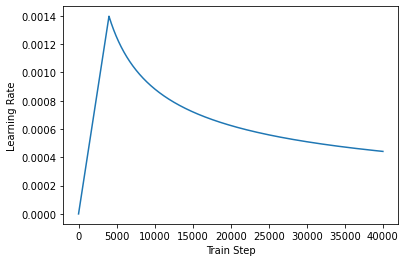

In [23]:
from matplotlib import pyplot as plt
plt.plot(leaning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
# plt.savefig(ROOT + '/data/lr.png')

## Begin the Training!

In [36]:
EPOCHS = 10
train_loss_values=[]
test_loss_values=[]

train_acc_values=[]
test_acc_values=[]## Begin the Training!

for epoch in range(EPOCHS):
#     print("Start of epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        
        # Include the start token which shifts sequence to the right
        dec_inputs = targets[:, :-1]
        
        # Target without the start token. The end token is included to know when the 
        # model reaches the end of the sequence
        dec_outputs_real = targets[:, 1:]
        
        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)
        
        # Calculate and apply the gradients
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
#         if batch % 50 == 0:
    print("Epoch: {} Training Loss: {:.4f} Training Accuracy: {:.4f} ".format(
                epoch+1, train_loss.result(), train_accuracy.result()))
    
    train_loss_values.append(train_loss.result())
    train_acc_values.append(train_accuracy.result())

Epoch: 1 Training Loss: 0.3179 Training Accuracy: 0.4377 
Epoch: 2 Training Loss: 0.3042 Training Accuracy: 0.4412 
Epoch: 3 Training Loss: 0.2939 Training Accuracy: 0.4435 
Epoch: 4 Training Loss: 0.2844 Training Accuracy: 0.4460 
Epoch: 5 Training Loss: 0.2728 Training Accuracy: 0.4492 
Epoch: 6 Training Loss: 0.2641 Training Accuracy: 0.4510 
Epoch: 7 Training Loss: 0.2548 Training Accuracy: 0.4536 
Epoch: 8 Training Loss: 0.2459 Training Accuracy: 0.4558 
Epoch: 9 Training Loss: 0.2398 Training Accuracy: 0.4576 
Epoch: 10 Training Loss: 0.2328 Training Accuracy: 0.4591 


# Defining Evaluation Fucntion

In [37]:
def evaluate(inp_sentence):
    '''
    Takes the input sentence.
    '''
    inp_sentence = [VOCAB_SIZE_EN-2] + tokenizer_en.encode(inp_sentence) + [VOCAB_SIZE_EN-1]
    
    # Expand dims to account for batch_size
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    # Start with the s-o-s
    output = tf.expand_dims([VOCAB_SIZE_FR-2], axis=0)
    
    for _ in range(MAX_LENGTH):
        predictions, attention_weights = transformer(enc_input, output, False)
        
        prediction = predictions[:, -1:, :]
#         print(predictions.shape)
        # Get highest probability
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        # If e-o-s return
        if predicted_id == VOCAB_SIZE_FR-1:
            return tf.squeeze(output, axis=0), attention_weights
        
        # Concat last prediction to decoder input
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attention_weights

# Defining a function to perform Translation

In [83]:
def translate(sentence, plot=''):
    #output, attention_weights
    output, attention_weights = evaluate(sentence) #.numpy()
#     print(f'wts shape: {attention_weights.keys()}')
    output = output.numpy()
    
    predicted_sentence = tokenizer_fr.decode(
        [i for i in output if i < VOCAB_SIZE_FR-2]
    )
    
    print("Input_English_Sentence: {}".format(sentence))
    print("Predicted translation into French: {}".format(predicted_sentence))
#     return predicted_sentence

# Testing the translation from English to French

In [84]:
translate("my country is great")

Input_English_Sentence: my country is great
Predicted translation into French: Mon pays est super.


In [85]:
translate("When I was in my 20s, I saw my very first psychotherapy client.")

Input_English_Sentence: When I was in my 20s, I saw my very first psychotherapy client.
Predicted translation into French: Quand j'étais dans mon 20, j'ai vu mon premier domaine très rifié les autres,


## Sample BLEU score calculation

In [90]:
##Bleu Score CAlculation

target= "Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute."
prediction = "Quand j'étais dans mon 20, j'ai vu mon premier domaine très rifié les autres"

target_seq = tokenizer_fr.encode(target)
target_tokens = [tokenizer_fr.decode([i]) for i in target_seq]

pred_seq = tokenizer_fr.encode(prediction)
preds = [tokenizer_fr.decode([i]) for i in pred_seq]

print(f"The BLEU Score for the above translation is: {sentence_bleu([target_tokens],preds)}")


The BLEU Score for the above translation is: 0.18669510440057904


# Ploting Train loss and Train Accuracy 

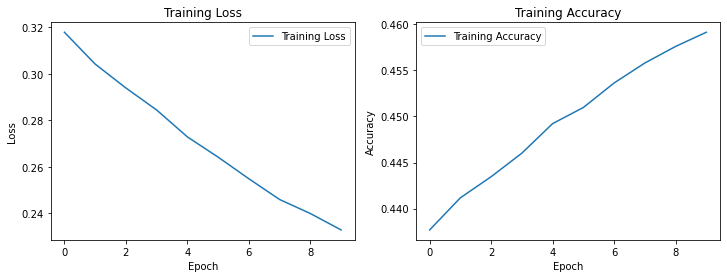

In [45]:
# Plotting
plt.figure(figsize=(12, 4))
 
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Training Accuracy')
# plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusion: The training loss is decreasing and training accuracy is increasing with the increase in the number of epochs. The BLEU score for a sample translated sentence is presented above. The model can perform better if trained for more epochs.